In [1]:
import numpy as np
#from autograd import numpy as anp, elementwise_grad as egrad
import theano as th
from theano import shared, function, tensor as tt
import pymc3 as pm

import math
import scipy.stats as st
import scipy

import pandas as pd
import io
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import sys

In [ ]:

!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4


In [3]:
from google.colab import files
data_to_load = files.upload()
df = pd.read_csv(io.BytesIO(data_to_load['Iso_data_4_pigs.csv']), index_col=0, header=None)

Saving Iso_data_4_pigs.csv to Iso_data_4_pigs.csv


In [4]:
Y = df.values
data = Y[:, :].flatten()


In [5]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
theta,0.965888,1.088688,1.000512,0.965744,1.033744,1.049744,0.937568,1.008912,1.094560,1.057888,0.920992,1.033536,1.145456,1.140736,1.035488,1.104832,1.165344,1.140960,1.085328,0.834000,1.010144,0.936624,1.067552,1.094832,0.959552,1.057760,1.115152,1.186512,1.258704,0.937632,1.085008,0.945136,1.033472,1.094464,0.981952,0.977136,1.130208,1.232256,1.264080,1.291200,...,1.353856,1.187200,1.205984,1.156672,0.990432,0.943936,1.015280,0.945792,0.858368,0.794320,1.166176,1.214240,1.311392,1.236912,1.101184,1.064448,0.948368,1.075808,1.060912,0.892896,1.422944,1.320576,1.285936,1.159296,1.167520,1.186720,1.078272,1.303872,1.198464,1.179968,1.245472,1.212992,1.361488,1.143856,1.120208,1.259664,1.260352,1.206160,1.267856,1.293120
theta_g,0.933448,1.032806,1.058790,0.977210,0.975809,1.055253,1.174705,1.224251,1.022238,1.074758,0.919683,1.000707,0.978304,1.111315,1.152684,1.098264,1.147320,1.080042,1.084738,1.458146,0.939252,0.955356,0.939533,0.993932,1.123031,1.121409,0.983188,0.965619,1.244675,1.546136,0.894105,0.971594,1.008948,0.963047,0.960064,0.871415,0.856923,0.903354,0.999807,1.161977,...,1.200035,1.192621,1.486624,1.284190,1.110482,1.150098,1.390292,1.436250,1.131304,0.611056,1.152622,1.411549,1.362125,1.337657,1.408390,1.330956,1.277285,1.141033,1.129999,1.129332,1.300154,1.439867,1.496381,1.095801,1.223408,1.369375,1.254777,1.204163,1.064587,1.058036,1.096279,1.620986,1.420073,1.434664,1.002634,1.346266,1.723698,1.167892,1.136519,1.188447
theta_p,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,...,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216,1.198216
time,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000


In [6]:
"""
th_data=data[0:500]
th_g_data=data[500:1000]
th_p_data=data[1000:1500]
time_data=data[1500:2000]
"""

"Currently Only Run through first 5 data points"
th_data=data[0:5];
th_g_data=data[500:505];
th_p_data=data[1000:1005];
time_data=data[1500:1505];


In [7]:
def Solver(k):
  num_pts=np.size(th_data)
  k = tt.exp(k) / 25
  n=np.size(th_data);
  dt=0.1;
  predict=tt.zeros(num_pts)
  for counter in range(0, num_pts):
    temp_th=th_data[counter]
    temp_th_p=th_p_data[counter]
    temp_time=time_data[counter]
    th_g_pred=1;
    th_g_pred_s=shared(th_g_pred)

    for t_step in np.arange(0.,temp_time,dt):
      th_g_dot=k*(temp_th*temp_th_p/th_g_pred-temp_th_p)
      th_g_pred_s=th_g_pred_s+th_g_dot*dt;
      

#    print('k',k.eval())
#   print('dt',dt)
#   print('th',temp_th)
#    print('th_g_dot',th_g_dot.eval())
#    print('th_g',th_g_pred_s.eval())
    predict=tt.set_subtensor(predict[counter:counter+1], th_g_pred_s)

  return predict


## Model 1
Error with Normal distrubution

In [8]:
model_A = pm.Model()
gamma2 = 100
sigma2 = 0.15
# define the distribution 
with model_A:
    x = pm.Normal(name='x',mu =0,sigma=tt.sqrt(gamma2),shape=1)
    y_mean = pm.Deterministic('y_mean', Solver(x))
    y = pm.Normal(name='y',mu=y_mean,sigma=tt.sqrt(sigma2),observed=th_g_data)

model_A


In [9]:
with model_A:
    mcmc_res_A = pm.sample(draws =5000, step=pm.NUTS(target_accept=0.99))

Sequential sampling (2 chains in 1 job)
NUTS: [x]
100%|██████████| 5500/5500 [00:18<00:00, 292.08it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
import warnings
warnings.filterwarnings("ignore")
fig = {'figsize':(12, 4)}
#pm.traceplot(mcmc_res_A)   

In [ ]:
_=pm.plot_autocorr(mcmc_res_A,var_names=['x'], combined=True)

In [14]:
mcmc_res_A_thin = mcmc_res_A[100::20]

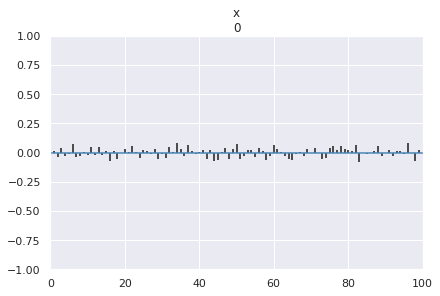

In [ ]:
_=pm.plot_autocorr(mcmc_res_A_thin,var_names=['x'], combined=True)

In [ ]:
ppsamples_A = pm.sample_posterior_predictive(samples=100,\
                                           model=model_A, 
                                           trace=mcmc_res_A_thin)['y']

100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


In [ ]:
post_sample_A=pm.sample_posterior_predictive(samples=100,model=model_A,trace=mcmc_res_A_thin)
print(post_['x'])

100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


In [ ]:
post_sample=pm.sampling.sample(model=model_A)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x]
Sampling chain 1, 107 divergences: 100%|██████████| 1000/1000 [00:06<00:00, 150.12it/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
print(post_sample[:]['x'])

In [ ]:
np.savetxt('20datapoints.txt',post_sample[:]['x'])
files.download('20datapoints.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 2
Error with InverseGamma Distrubution

In [16]:
model_C = pm.Model()
alpha1 =3.
beta1 = 0.05
alpha2 = 1.0
# define the distribution 
with model_C:
    sigma2s = pm.InverseGamma('sigma2s',alpha=alpha1,beta=beta1,shape=1)
    sigma2 = pm.Deterministic('sigma2',tt.tile(sigma2s,5))
    gamma2 = pm.Exponential(name='gamma2',lam=alpha2)
    x = pm.Normal(name='x',mu =0,sigma=tt.sqrt(gamma2),shape=1)
    y_mean = pm.Deterministic('y_mean', Solver(x))
    y = pm.Normal(name='y',mu=y_mean,sigma=tt.sqrt(sigma2),observed=th_g_data)

In [17]:
# generate samples from x 
with model_C:
    mcmc_res_C = pm.sample(draws = 1500, step=pm.NUTS())

Sequential sampling (2 chains in 1 job)
NUTS: [x, gamma2, sigma2s]
100%|██████████| 2000/2000 [00:10<00:00, 195.35it/s]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
mcmc_res_C_thin = mcmc_res_C[50::10]

In [19]:
ppsamples_C = pm.sample_posterior_predictive(samples=100,\
                                           model=model_C, 
                                           trace=mcmc_res_C_thin)['y']

100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


In [20]:
post_sample=pm.sampling.sample(model=model_C)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, gamma2, sigma2s]
100%|██████████| 1000/1000 [00:10<00:00, 99.91it/s]
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
print(post_sample[:]['x'])